# 相似度筛选

In [1]:
import os
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler,QuantileTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# 加载数据
df = pd.read_csv(r"F:\cache_data\frequency_filter\dy\dy_frequency_dz_dl.csv")

In [3]:
df.fillna(df.select_dtypes(include='number').mean(),inplace=True)

In [4]:
df.columns

Index(['TZ', 'DEM', 'AnalyticalHillshading', 'Aspect',
       'ChannelNetworkBaseLevel', 'ChannelNetworkDistance',
       'ClosedDepressions', 'ConvergenceIndex', 'LSFactor', 'PlanCurvature',
       'ProfileCurvature', 'RelativeSlopePosition', 'Slope',
       'TopographicWetnessIndex', 'TotalCatchmentArea', 'ValleyDepth',
       'Contrast', 'Correlation', 'Dissimilarity', 'Entropy', 'Homogeneity',
       'Mean', 'ndvi', 'PCA_0', 'PCA_1', 'SecondMoment', 'Variance', 'PRE',
       'SRA', 'TMP', 'VAP', 'WIND', 'BIO', 'LON', 'LAT', 'PH', 'DL', 'DZ'],
      dtype='object')

In [5]:
feature_columns = ['DEM', 'AnalyticalHillshading', 'Aspect',
       'ChannelNetworkBaseLevel', 'ChannelNetworkDistance',
       'ClosedDepressions', 'ConvergenceIndex', 'LSFactor', 'PlanCurvature',
       'ProfileCurvature', 'RelativeSlopePosition', 'Slope',
       'TopographicWetnessIndex', 'TotalCatchmentArea', 'ValleyDepth',
       'Contrast', 'Correlation', 'Dissimilarity', 'Entropy', 'Homogeneity',
       'Mean', 'ndvi', 'PCA_0', 'PCA_1', 'SecondMoment', 'Variance', 'PRE',
       'SRA', 'TMP', 'VAP', 'WIND', 'BIO', 'LON', 'LAT', 'PH', 'DL', 'DZ']

In [6]:
label_column = 'TZ'

# 获取标签的唯一值
label_values = df[label_column].unique()

# 初始化用于存储代表性样本的列表
representative_samples = []

# 设置相似度阈值
threshold = 0.9  # 根据需要调整

# 遍历每个标签值
for label_value in label_values:
    # 提取当前标签值的样本
    label_df = df[df[label_column] == label_value]
    
    # 检查样本数量
    num_samples = len(label_df)
    if num_samples == 1:
        # 如果样本数量为1，直接添加该样本
        representative_samples.append(label_df.iloc[0].values)
    else:
        # 对特征进行标准化
        scaler = StandardScaler()
        # scaler = MinMaxScaler()
        # scaler = MaxAbsScaler()
        # scaler = QuantileTransformer()
        features_scaled = scaler.fit_transform(label_df[feature_columns])

        # 计算样本间的余弦相似度
        similarity_matrix = cosine_similarity(features_scaled)

        # 初始化用于存储选定样本索引的集合
        selected_samples = set()

        # 遍历相似度矩阵，选择相似度高于阈值的样本
        for i in range(len(similarity_matrix)):
            for j in range(i + 1, len(similarity_matrix)):
                if similarity_matrix[i, j] > threshold:
                    selected_samples.add(i)
                    selected_samples.add(j)

        if len(selected_samples) == 0:
            # 如果selected_samples为空，添加相似度最高的15%的样本
            num_to_add = math.ceil(0.75 * num_samples)
            if num_to_add > 0:
                top_indices = similarity_matrix.sum(axis=0).argsort()[::-1][:num_to_add]
                selected_samples.update(top_indices)

        # 从原始样本中提取选定的样本
        selected_samples_indices = label_df.index[list(selected_samples)]
        representative_samples.extend(df.loc[selected_samples_indices].values)

# 转换为 DataFrame 并显示部分结果
representative_samples_df = pd.DataFrame(representative_samples, columns=df.columns)


In [7]:
len(representative_samples_df)

3651

In [8]:
# 检查类别是否丢失
old_type = df['TZ'].value_counts()
new_type = representative_samples_df['TZ'].value_counts()
old_type.shape,new_type.shape

((98,), (98,))

In [9]:
out_path = r"F:\cache_data\frequency_filter\dy\scaler_csv"
representative_samples_df.to_csv(os.path.join(out_path,'dy_stander_DLDZ.csv'))

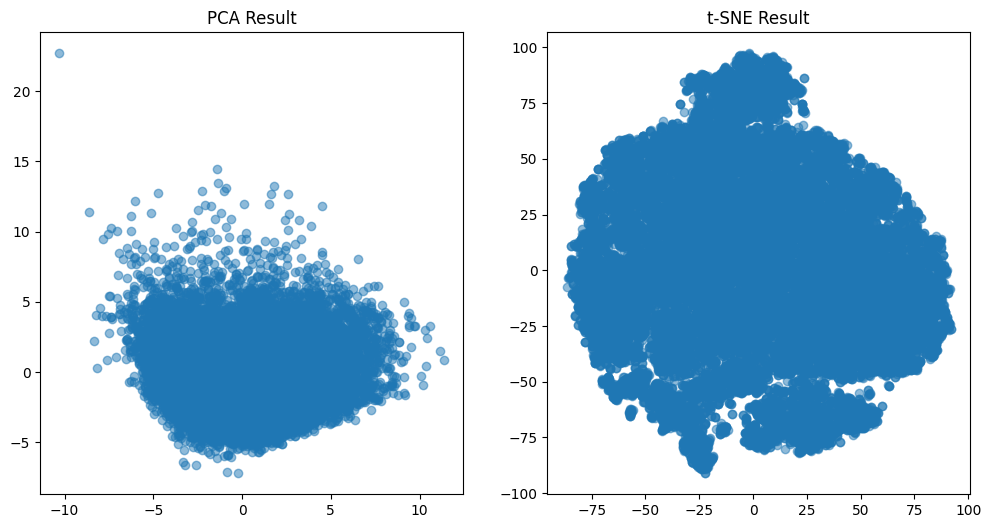

(array([[-0.00509827, -2.67832127, -5.03313112, ...,  0.26810631,
         -0.15693803, -0.02106798],
        [-2.07143943, -0.15894635, -1.86596989, ...,  0.00769023,
          0.06788736, -0.0592512 ],
        [-2.47663257,  0.23952343, -1.39515123, ..., -0.15491505,
         -0.07500168,  0.00907001],
        ...,
        [ 0.97174003, -1.08509089,  1.13502634, ...,  0.1428572 ,
          0.01136814,  0.04989086],
        [ 1.95038783, -4.45391115,  1.39727357, ..., -0.30625096,
          0.00889678, -0.10487131],
        [-0.30057708, -1.09221973,  2.8062716 , ...,  0.0293799 ,
         -0.09855393, -0.0987796 ]]),
 array([[ 34.127563  ,  52.437145  ],
        [ -6.07313   ,  51.145325  ],
        [-28.129272  ,  -2.026564  ],
        ...,
        [ -0.38690984, -25.303246  ],
        [  8.603298  , -62.175323  ],
        [ -7.575064  , -28.776663  ]], dtype=float32))

In [18]:
import warnings
features = df.drop(columns=['TL', 'YL', 'TS', 'TZ'])
# 禁用 FutureWarning 类型的警告
warnings.simplefilter(action='ignore', category=FutureWarning)

# 执行代码

# 恢复警告设置
# warnings.resetwarnings()

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 对特征进行标准化
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 应用 PCA
pca = PCA(n_components=30)
pca_result = pca.fit_transform(features_scaled)

# 应用 t-SNE，明确设置 init 为 'pca'
tsne = TSNE(n_components=2, random_state=0, init='pca', learning_rate='auto')  # 显式设置 init 和 learning_rate
tsne_result = tsne.fit_transform(features_scaled)

# 可视化 PCA 和 t-SNE 的结果
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title('PCA Result')

plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.5)
plt.title('t-SNE Result')

plt.show()

# 返回 PCA 和 t-SNE 结果以供进一步分析
pca_result, tsne_result


In [128]:
# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# 应用 PCA
pca = PCA(n_components=2)  # 使用两个主成分
X_pca = pca.fit_transform(X_scaled)

# 找到在第一主成分上具有最大和最小投影值的样本索引
first_pc = X_pca[:, 0]
representative_sample_indices = np.argpartition(first_pc, [0, -1])[:2]

# 选取具有代表性的样本
representative_samples = features.iloc[representative_sample_indices]

representative_samples

,DEM,AnalyticalHillshading,Aspect,ChannelNetworkBaseLevel,ChannelNetworkDistance,ClosedDepressions,ConvergenceIndex,LSFactor,PlanCurvature,ProfileCurvature,...,SecondMoment,Variance,PRE,SRA,TMP,VAP,WIND,BIO,LON,LAT
888,821.6,0.815088,3.894732,821.11770,0.48230,13.92083,-8.179223,27.389524,-0.018204,-0.019513,...,0.185185,4.666667,100.333336,13112.750,15.925000,1.568333,1.625000,192.72514,446545.0,2876000.0
1,870.8,1.131889,1.264116,835.30994,35.49005,13.92083,-2.361449,18.948938,-0.010550,-0.010593,...,0.185185,0.913580,101.916664,13154.333,15.766666,1.555833,1.658333,194.86105,443845.0,2861300.0


In [150]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity


# 应用 PCA
pca = PCA(n_components=2)  # 降至2维进行可视化
pca_result = pca.fit_transform(features)

# 计算样本在 PCA 降维后的空间中的坐标
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# 计算样本的密度
kde = KernelDensity(bandwidth=2)  # 根据需要调整 bandwidth
kde.fit(pca_result)

# 计算密度得分
density_scores = kde.score_samples(pca_result)

# 选择高密度样本
threshold = np.percentile(density_scores, 90)  # 根据需要调整阈值
high_density_samples = df[density_scores >= threshold]

# 显示高密度样本
print(high_density_samples)


      Unnamed: 0  TL  YL     TS            TZ     DEM  AnalyticalHillshading  \
0              0  黄壤  黄壤  硅铁质黄壤  薄腐殖层厚土层硅铁质黄壤   961.5               0.706572   
1              2  黄壤  黄壤  硅铁质黄壤  薄腐殖层厚土层硅铁质黄壤   870.8               1.131889   
6              8  黄壤  黄壤  硅铁质黄壤  薄腐殖层厚土层硅铁质黄壤   869.8               0.820064   
8             10  黄壤  黄壤  硅铁质黄壤  薄腐殖层厚土层硅铁质黄壤   847.1               0.733430   
16            21  黄壤  黄壤  硅铁质黄壤  薄腐殖层厚土层硅铁质黄壤   854.1               1.295619   
...          ...  ..  ..    ...           ...     ...                    ...   
1826        4973  黄壤  黄壤  硅铝质黄壤  薄腐殖层厚土层硅铝质黄壤  1031.5               0.522569   
1897        5136  黄壤  黄壤  硅铝质黄壤  薄腐殖层中土层硅铝质黄壤   983.8               1.281300   
1902        5142  黄壤  黄壤  硅铁质黄壤  薄腐殖层厚土层硅铁质黄壤   892.1               1.096558   
1963        5255  黄壤  黄壤  硅铝质黄壤  薄腐殖层薄土层硅铝质黄壤  1094.9               0.246648   
1997        5337  黄壤  黄壤  硅铁质黄壤  薄腐殖层厚土层硅铁质黄壤   838.9               0.785740   

        Aspect  ChannelNetworkBaseLevel

In [ ]:
# from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler,QuantileTransformer
# label_column = 'TL'

# # 获取标签的唯一值
# label_values = df[label_column].unique()

# # 初始化用于存储代表性样本的列表
# representative_samples = []

# # 设置相似度阈值
# threshold = 0.9  # 根据需要调整

# # 遍历每个标签值
# for label_value in label_values:
#     # 提取当前标签值的样本
#     label_df = df[df[label_column] == label_value]
#     # 对特征进行标准化
#     scaler = StandardScaler()
#     # scaler = MinMaxScaler()
#     # scaler = MaxAbsScaler()
#     # scaler = QuantileTransformer()
#     features_scaled = scaler.fit_transform(label_df[feature_columns])

#     # 计算样本间的余弦相似度
#     similarity_matrix = cosine_similarity(features_scaled)
#     print(similarity_matrix)
#     # 初始化用于存储选定样本索引的集合
#     selected_samples = set()

#     # 遍历相似度矩阵，选择相似度高于阈值的样本
#     for i in range(len(similarity_matrix)):
#         for j in range(i + 1, len(similarity_matrix)):
#             if similarity_matrix[i, j] > threshold:
#                 selected_samples.add(i)
#                 selected_samples.add(j)

#     # 从原始样本中提取选定的样本
#     selected_samples_indices = label_df.index[list(selected_samples)]
#     representative_samples.extend(df.loc[selected_samples_indices].values)

# # 转换为 DataFrame 并显示部分结果
# representative_samples_df = pd.DataFrame(representative_samples, columns=df.columns)

